In [99]:
import numpy as np
import pandas as pd
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Model
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding, Input, concatenate, Reshape
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [5]:
df = pd.read_csv('pakwheels.csv',index_col=0)
df.head()

,ad_url,title,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated,car_features,description
0,https://www.pakwheels.com/used-cars/honda-civi...,Honda Civic VTi Oriel Prosmatec 1.8 i-VTEC 2007,Islamabad Islamabad,2007.0,PKR 16.5 lacs,"100,000 km",Petrol,Automatic,Lahore,Grey,Imported Cars,1800 cc,Sedan,"Oct 09, 2022",ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,2007 model full option Chat piller geniune or ...
1,https://www.pakwheels.com/used-cars/suzuki-meh...,Suzuki Mehran VX Euro II 2012,"Eden Gardens, Faisalabad Punjab",2012.0,PKR 7 lacs,"100,000 km",Petrol,Manual,Faisalabad,Grey,Imported Cars,800 cc,Hatchback,"Oct 09, 2022",AM/FM Radio\nCD Player\nImmobilizer Key,"Very smooth drive,70% in orignal paint rest of..."
2,https://www.pakwheels.com/used-cars/honda-civi...,Honda Civic EX 1995,"Bostan Road, Rawalpindi Punjab",1995.0,PKR 7.6 lacs,999 km,Petrol,Manual,Lahore,Black,Imported Cars,1500 cc,Sedan,"Oct 09, 2022",AM/FM Radio\nAir Conditioning\nAlloy Rims\nCas...,1600cc Engine installed Alloy RimsAir Conditio...
3,https://www.pakwheels.com/used-cars/toyota-for...,Toyota Fortuner 2.7 VVTi 2013,"Kallar Kahar Road, Chakwal Punjab",2013.0,PKR 70 lacs,"94,000 km",Petrol,Automatic,Lahore,Black,Imported Cars,2700 cc,SUV,"Oct 09, 2022",ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,Inside out fully original. Original return fil...
4,https://www.pakwheels.com/used-cars/suzuki-meh...,Suzuki Mehran VX Euro II 2015,Muzaffar Gargh Punjab,2015.0,PKR 8 lacs,"86,000 km",Petrol,Manual,Multan,Grey,Imported Cars,796 cc,Hatchback,"Oct 09, 2022",AM/FM Radio\nCD Player\nImmobilizer Key,gari total genion hy.chill a.c.new tires.no wo...


In [6]:
df.shape

(89956, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89956 entries, 0 to 89955
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ad_url           89956 non-null  object 
 1   title            89956 non-null  object 
 2   location         89954 non-null  object 
 3   model_year       87449 non-null  float64
 4   price            89954 non-null  object 
 5   mileage          89954 non-null  object 
 6   engine_type      89001 non-null  object 
 7   transmission     89954 non-null  object 
 8   registered_in    89954 non-null  object 
 9   color            88093 non-null  object 
 10  assembly         89956 non-null  object 
 11  engine_capacity  89954 non-null  object 
 12  body_type        81407 non-null  object 
 13  ad_last_updated  89954 non-null  object 
 14  car_features     83435 non-null  object 
 15  description      89954 non-null  object 
dtypes: float64(1), object(15)
memory usage: 11.7+ MB


# Cleaning the data set

In [8]:
if df.duplicated().any():
    df = df.drop_duplicates()

In [9]:
df.isna().sum()

ad_url                0
title                 0
location              2
model_year         2507
price                 2
mileage               2
engine_type         955
transmission          2
registered_in         2
color              1863
assembly              0
engine_capacity       2
body_type          8549
ad_last_updated       2
car_features       6521
description           2
dtype: int64

Changing datatype of date colums:

In [10]:
df['ad_last_updated'] = pd.to_datetime(df['ad_last_updated'])

Removing un-needed colums:

In [11]:
df.drop(['ad_url'],axis=1,inplace=True)

Standradizing price

In [12]:
df.price.head()

0    PKR 16.5 lacs
1       PKR 7 lacs
2     PKR 7.6 lacs
3      PKR 70 lacs
4       PKR 8 lacs
Name: price, dtype: object

In [13]:
df['unit'] = df['price'].str.extract(r'(\blacs?\b|\bcrores?\b)', flags=re.IGNORECASE)
df['unit'].head()

0    lacs
1    lacs
2    lacs
3    lacs
4    lacs
Name: unit, dtype: object

In [14]:
df['unit'].value_counts()

unit
lacs     85820
crore     2726
Name: count, dtype: int64

In [15]:
df['unit'].isna().sum()

1410

In [16]:
#removing text that appear in the price colum which are pkr callfor and call for and any empty spaces etc etc
df['price']=df['price'].str.replace('PKR','')

In [17]:
df['price']=df['price'].str.replace('Callfor','').str.replace('Call for','').str.replace(' ','')

In [18]:
df['price'] = df['price'].str.replace('lacs', '').str.replace('lac', '')

In [19]:
df['price'] = df['price'].str.replace('crore', '').str.replace('price','')

In [20]:
df['price'] = df['price'].str.replace(',', '')

In [21]:
df['price'] = df['price'].replace('', np.nan)

In [22]:
df.price.head()

0    16.5
1       7
2     7.6
3      70
4       8
Name: price, dtype: object

In [23]:
df['price'] = pd.to_numeric(df['price'])

In [24]:
df['price'] = np.where(df['unit'].str.lower() == 'crore', df['price'] * 10000000, df['price'] * 100000)
df['price']

0        1650000.0
1         700000.0
2         760000.0
3        7000000.0
4         800000.0
           ...    
89951    3000000.0
89952    3750000.0
89953    2235000.0
89954    1550000.0
89955     730000.0
Name: price, Length: 89956, dtype: float64

In [25]:
print('NAN',df['price'].isna().sum()) # checking for missing values

NAN 1407


In [26]:
df['price']=df['price'].fillna(df['price'].median())

Now working on model_year

In [27]:
df['model_year'] = df['model_year'].astype('Int64')

In [28]:
print('NAN',df['model_year'].isna().sum())

NAN 2507


In [29]:
def extract_make_year(title):
    match = re.search(r'\b\d{4}\b', str(title))
    if match:
        year = int(match.group())
        # Filter out unreasonable years
        if 1900 <= year <= 2023 and year <= pd.Timestamp.now().year:
            return year
    return None

In [30]:
df.loc[df['model_year'].isna(), 'model_year'] = df.loc[df['model_year'].isna(), 'title'].apply(extract_make_year)

In [31]:
print('NAN',df['model_year'].isna().sum())

NAN 19


In [32]:
min_model_year = df['model_year'].min()
max_model_year = df['model_year'].max()

print("Minimum Model Year:", min_model_year)
print("Maximum Model Year:", max_model_year)

Minimum Model Year: 1950
Maximum Model Year: 2022


In [33]:
df.dropna(subset=['model_year'], inplace=True)
print('NAN',df['model_year'].isna().sum())

NAN 0


Extracting meaning full information from the tilte

In [34]:
df['brand'] = df.title.apply(lambda x:(x.split(' ')[0]))

In [35]:
df['vehicle'] = df.title.apply(lambda x:(x.split(' ')[1]))

In [36]:
def subtract_info(row):
    title = row['title']
    brand = row['brand']
    vehicle = row['vehicle']
    model_year = str(row['model_year'])

    result = title.replace(brand, '').replace(vehicle, '').replace(model_year, '')
    return result

In [37]:
df['make'] = df.apply(subtract_info, axis=1)

In [38]:
df.make.isna().sum()

0

In [39]:
df.head()

,title,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated,car_features,description,unit,brand,vehicle,make
0,Honda Civic VTi Oriel Prosmatec 1.8 i-VTEC 2007,Islamabad Islamabad,2007,1650000.0,"100,000 km",Petrol,Automatic,Lahore,Grey,Imported Cars,1800 cc,Sedan,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,2007 model full option Chat piller geniune or ...,lacs,Honda,Civic,VTi Oriel Prosmatec 1.8 i-VTEC
1,Suzuki Mehran VX Euro II 2012,"Eden Gardens, Faisalabad Punjab",2012,700000.0,"100,000 km",Petrol,Manual,Faisalabad,Grey,Imported Cars,800 cc,Hatchback,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,"Very smooth drive,70% in orignal paint rest of...",lacs,Suzuki,Mehran,VX Euro II
2,Honda Civic EX 1995,"Bostan Road, Rawalpindi Punjab",1995,760000.0,999 km,Petrol,Manual,Lahore,Black,Imported Cars,1500 cc,Sedan,2022-10-09,AM/FM Radio\nAir Conditioning\nAlloy Rims\nCas...,1600cc Engine installed Alloy RimsAir Conditio...,lacs,Honda,Civic,EX
3,Toyota Fortuner 2.7 VVTi 2013,"Kallar Kahar Road, Chakwal Punjab",2013,7000000.0,"94,000 km",Petrol,Automatic,Lahore,Black,Imported Cars,2700 cc,SUV,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,Inside out fully original. Original return fil...,lacs,Toyota,Fortuner,2.7 VVTi
4,Suzuki Mehran VX Euro II 2015,Muzaffar Gargh Punjab,2015,800000.0,"86,000 km",Petrol,Manual,Multan,Grey,Imported Cars,796 cc,Hatchback,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,gari total genion hy.chill a.c.new tires.no wo...,lacs,Suzuki,Mehran,VX Euro II


Standradizing Milage

In [40]:
df['mileage'] =df['mileage'].str.replace(',','').str.replace(' km','')
df['mileage'] = pd.to_numeric(df['mileage'])

In [41]:
df['mileage']

0        100000
1        100000
2           999
3         94000
4         86000
          ...  
89951     65000
89952    114000
89953    152000
89954    104000
89955    258456
Name: mileage, Length: 89937, dtype: int64

In [42]:
df['mileage'].isna().sum()

0

Standradzing Engine capacity

In [43]:
df['ev'] = df['engine_capacity'].str.contains('kWh').astype(int)

In [44]:
df['engine_capacity'].str.contains(' kWh').value_counts()

engine_capacity
False    89803
True       134
Name: count, dtype: int64

In [45]:
df['engine_capacity'] = df['engine_capacity'].str.replace(' cc','').str.replace(' kWh','')

In [46]:
df['engine_capacity'] = pd.to_numeric(df['engine_capacity'])

In [47]:
df['engine_capacity'].isna().sum()

0

In [48]:
df.head()

,title,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated,car_features,description,unit,brand,vehicle,make,ev
0,Honda Civic VTi Oriel Prosmatec 1.8 i-VTEC 2007,Islamabad Islamabad,2007,1650000.0,100000,Petrol,Automatic,Lahore,Grey,Imported Cars,1800.0,Sedan,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,2007 model full option Chat piller geniune or ...,lacs,Honda,Civic,VTi Oriel Prosmatec 1.8 i-VTEC,0
1,Suzuki Mehran VX Euro II 2012,"Eden Gardens, Faisalabad Punjab",2012,700000.0,100000,Petrol,Manual,Faisalabad,Grey,Imported Cars,800.0,Hatchback,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,"Very smooth drive,70% in orignal paint rest of...",lacs,Suzuki,Mehran,VX Euro II,0
2,Honda Civic EX 1995,"Bostan Road, Rawalpindi Punjab",1995,760000.0,999,Petrol,Manual,Lahore,Black,Imported Cars,1500.0,Sedan,2022-10-09,AM/FM Radio\nAir Conditioning\nAlloy Rims\nCas...,1600cc Engine installed Alloy RimsAir Conditio...,lacs,Honda,Civic,EX,0
3,Toyota Fortuner 2.7 VVTi 2013,"Kallar Kahar Road, Chakwal Punjab",2013,7000000.0,94000,Petrol,Automatic,Lahore,Black,Imported Cars,2700.0,SUV,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,Inside out fully original. Original return fil...,lacs,Toyota,Fortuner,2.7 VVTi,0
4,Suzuki Mehran VX Euro II 2015,Muzaffar Gargh Punjab,2015,800000.0,86000,Petrol,Manual,Multan,Grey,Imported Cars,796.0,Hatchback,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,gari total genion hy.chill a.c.new tires.no wo...,lacs,Suzuki,Mehran,VX Euro II,0


In [49]:
df.isna().sum()

title                 0
location              0
model_year            0
price                 0
mileage               0
engine_type         953
transmission          0
registered_in         0
color              1861
assembly              0
engine_capacity       0
body_type          8545
ad_last_updated       0
car_features       6518
description           0
unit               1408
brand                 0
vehicle               0
make                  0
ev                    0
dtype: int64

dropping irrelevent cloums

In [50]:
df.drop(['unit','title'],axis=1,inplace=True)

In [51]:
df.head()

,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated,car_features,description,brand,vehicle,make,ev
0,Islamabad Islamabad,2007,1650000.0,100000,Petrol,Automatic,Lahore,Grey,Imported Cars,1800.0,Sedan,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,2007 model full option Chat piller geniune or ...,Honda,Civic,VTi Oriel Prosmatec 1.8 i-VTEC,0
1,"Eden Gardens, Faisalabad Punjab",2012,700000.0,100000,Petrol,Manual,Faisalabad,Grey,Imported Cars,800.0,Hatchback,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,"Very smooth drive,70% in orignal paint rest of...",Suzuki,Mehran,VX Euro II,0
2,"Bostan Road, Rawalpindi Punjab",1995,760000.0,999,Petrol,Manual,Lahore,Black,Imported Cars,1500.0,Sedan,2022-10-09,AM/FM Radio\nAir Conditioning\nAlloy Rims\nCas...,1600cc Engine installed Alloy RimsAir Conditio...,Honda,Civic,EX,0
3,"Kallar Kahar Road, Chakwal Punjab",2013,7000000.0,94000,Petrol,Automatic,Lahore,Black,Imported Cars,2700.0,SUV,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,Inside out fully original. Original return fil...,Toyota,Fortuner,2.7 VVTi,0
4,Muzaffar Gargh Punjab,2015,800000.0,86000,Petrol,Manual,Multan,Grey,Imported Cars,796.0,Hatchback,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,gari total genion hy.chill a.c.new tires.no wo...,Suzuki,Mehran,VX Euro II,0


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89937 entries, 0 to 89955
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   location         89937 non-null  object        
 1   model_year       89937 non-null  Int64         
 2   price            89937 non-null  float64       
 3   mileage          89937 non-null  int64         
 4   engine_type      88984 non-null  object        
 5   transmission     89937 non-null  object        
 6   registered_in    89937 non-null  object        
 7   color            88076 non-null  object        
 8   assembly         89937 non-null  object        
 9   engine_capacity  89937 non-null  float64       
 10  body_type        81392 non-null  object        
 11  ad_last_updated  89937 non-null  datetime64[ns]
 12  car_features     83419 non-null  object        
 13  description      89937 non-null  object        
 14  brand            89937 non-null  object    

Now handling null values:

In [53]:
df['engine_type'].value_counts()

engine_type
Petrol    82032
Diesel     4085
Hybrid     2867
Name: count, dtype: int64

In [54]:
df['engine_type'].isna().sum()

953

In [55]:
df['engine_type'].fillna('Unknown', inplace=True)

In [56]:
df['color'].value_counts()

color
White        39965
Silver       13914
Black        12261
Grey          8111
Blue          3761
Green         1635
Red           1630
Gold          1519
Maroon        1333
Beige          907
Burgundy       575
Brown          466
Turquoise      396
Bronze         371
Navy           287
Pink           230
Unlisted       205
Indigo         145
Purple         142
Yellow         140
Orange          79
Magenta          3
Wine             1
Name: count, dtype: int64

In [57]:
df['color'].isna().sum()

1861

In [58]:
df['color'].fillna('Unknown', inplace=True)

Extracting current city from the location coloum

In [59]:
city_pattern = r'(\b(?:Karachi|Lahore|Islamabad|Rawalpindi|Multan|Faisalabad|Quetta|Peshawar|Sialkot|Gujranwala|Hyderabad|Sukkur|Bahawalpur|Abbottabad|Sargodha|Gujrat|Sahiwal|Jhang|Okara|Attock|Sahiwal|Sukkur|Larkana|Nawabshah|Mirpur Khas|Jacobabad|Kandhkot|Kasur|Dera Ghazi Khan|Nankana Sahib|Sheikhupura|Jhelum|Hafizabad|Kohat|Karak|Bannu|Mardan|Swabi|Swat|Charsadda|Haripur|Mansehra|Chitral|Pakpattan|Chiniot|Vehari|Burewala|Sadiqabad|Khuzdar|Quetta|Gwadar|Turbat|Hub|Loralai|Zhob|Dera Ismail Khan|Nowshera|Mingora|Muzaffarabad|Mirpur|Kotli|Bagh|Rawalakot|Chakwal|Muzaffar Gargh)\b)'

In [60]:
# Extract city using regular expressions
df['current_city'] = df['location'].str.extract(city_pattern, expand=False, flags=re.IGNORECASE).fillna('Unknown')

In [61]:
df.head()

,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated,car_features,description,brand,vehicle,make,ev,current_city
0,Islamabad Islamabad,2007,1650000.0,100000,Petrol,Automatic,Lahore,Grey,Imported Cars,1800.0,Sedan,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,2007 model full option Chat piller geniune or ...,Honda,Civic,VTi Oriel Prosmatec 1.8 i-VTEC,0,Islamabad
1,"Eden Gardens, Faisalabad Punjab",2012,700000.0,100000,Petrol,Manual,Faisalabad,Grey,Imported Cars,800.0,Hatchback,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,"Very smooth drive,70% in orignal paint rest of...",Suzuki,Mehran,VX Euro II,0,Faisalabad
2,"Bostan Road, Rawalpindi Punjab",1995,760000.0,999,Petrol,Manual,Lahore,Black,Imported Cars,1500.0,Sedan,2022-10-09,AM/FM Radio\nAir Conditioning\nAlloy Rims\nCas...,1600cc Engine installed Alloy RimsAir Conditio...,Honda,Civic,EX,0,Rawalpindi
3,"Kallar Kahar Road, Chakwal Punjab",2013,7000000.0,94000,Petrol,Automatic,Lahore,Black,Imported Cars,2700.0,SUV,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,Inside out fully original. Original return fil...,Toyota,Fortuner,2.7 VVTi,0,Chakwal
4,Muzaffar Gargh Punjab,2015,800000.0,86000,Petrol,Manual,Multan,Grey,Imported Cars,796.0,Hatchback,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,gari total genion hy.chill a.c.new tires.no wo...,Suzuki,Mehran,VX Euro II,0,Muzaffar Gargh


In [62]:
df['current_city'].isna().sum()

0

In [63]:
df['location'].value_counts()

location
 Lahore Punjab                      2616
 Islamabad Islamabad                2568
 Karachi Sindh                      2535
 DHA Defence, Lahore Punjab         1996
 Johar Town, Lahore Punjab          1459
                                    ... 
 Gobind Pura, Faisalabad Punjab        1
 Malke Khurd, Sialkot Punjab           1
 Dera Allah Yar Balochistan            1
 Walait Homes, Rawalpindi Punjab       1
 Sufaid Dheri, Peshawar KPK            1
Name: count, Length: 2416, dtype: int64

In [64]:
ac_presence_patterns = r'\b(?:ac|air conditioning|air conditioning working|ac working|ac available|air conditioning available)\b'
ac_absence_patterns = r'\b(?:no ac|no air conditioning|ac not working|air conditioning not working|ac not available|air conditioning not available)\b'

In [65]:
df['has_ac'] = np.where(df['car_features'].str.contains(ac_presence_patterns, case=False, na=False) & ~df['car_features'].str.contains(ac_absence_patterns, case=False, na=False), 1, 0)

In [66]:
df['has_ac'].value_counts()

has_ac
1    78092
0    11845
Name: count, dtype: int64

In [67]:
df.head()

,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated,car_features,description,brand,vehicle,make,ev,current_city,has_ac
0,Islamabad Islamabad,2007,1650000.0,100000,Petrol,Automatic,Lahore,Grey,Imported Cars,1800.0,Sedan,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,2007 model full option Chat piller geniune or ...,Honda,Civic,VTi Oriel Prosmatec 1.8 i-VTEC,0,Islamabad,1
1,"Eden Gardens, Faisalabad Punjab",2012,700000.0,100000,Petrol,Manual,Faisalabad,Grey,Imported Cars,800.0,Hatchback,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,"Very smooth drive,70% in orignal paint rest of...",Suzuki,Mehran,VX Euro II,0,Faisalabad,0
2,"Bostan Road, Rawalpindi Punjab",1995,760000.0,999,Petrol,Manual,Lahore,Black,Imported Cars,1500.0,Sedan,2022-10-09,AM/FM Radio\nAir Conditioning\nAlloy Rims\nCas...,1600cc Engine installed Alloy RimsAir Conditio...,Honda,Civic,EX,0,Rawalpindi,1
3,"Kallar Kahar Road, Chakwal Punjab",2013,7000000.0,94000,Petrol,Automatic,Lahore,Black,Imported Cars,2700.0,SUV,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,Inside out fully original. Original return fil...,Toyota,Fortuner,2.7 VVTi,0,Chakwal,1
4,Muzaffar Gargh Punjab,2015,800000.0,86000,Petrol,Manual,Multan,Grey,Imported Cars,796.0,Hatchback,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,gari total genion hy.chill a.c.new tires.no wo...,Suzuki,Mehran,VX Euro II,0,Muzaffar Gargh,0


Using NLTK on description and car_features

In [68]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [69]:
df['cleaned_description'] = df['description'].apply(clean_text)

Adding a new colum called AGE:

In [70]:
current_year = pd.to_datetime('today').year
df['age'] = current_year - df['model_year']

Removing un-nneded colums:

In [71]:
df.drop(['description'],axis=1,inplace=True)

In [72]:
df.head()

,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,...,ad_last_updated,car_features,brand,vehicle,make,ev,current_city,has_ac,cleaned_description,age
0,Islamabad Islamabad,2007,1650000.0,100000,Petrol,Automatic,Lahore,Grey,Imported Cars,1800.0,...,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,Honda,Civic,VTi Oriel Prosmatec 1.8 i-VTEC,0,Islamabad,1,2007 model full option chat piller geniune inn...,16
1,"Eden Gardens, Faisalabad Punjab",2012,700000.0,100000,Petrol,Manual,Faisalabad,Grey,Imported Cars,800.0,...,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,Suzuki,Mehran,VX Euro II,0,Faisalabad,0,smooth drive 70 orignal paint rest shower with...,11
2,"Bostan Road, Rawalpindi Punjab",1995,760000.0,999,Petrol,Manual,Lahore,Black,Imported Cars,1500.0,...,2022-10-09,AM/FM Radio\nAir Conditioning\nAlloy Rims\nCas...,Honda,Civic,EX,0,Rawalpindi,1,1600cc engine installed alloy rimsair conditio...,28
3,"Kallar Kahar Road, Chakwal Punjab",2013,7000000.0,94000,Petrol,Automatic,Lahore,Black,Imported Cars,2700.0,...,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,Toyota,Fortuner,2.7 VVTi,0,Chakwal,1,inside fully original original return file ava...,10
4,Muzaffar Gargh Punjab,2015,800000.0,86000,Petrol,Manual,Multan,Grey,Imported Cars,796.0,...,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,Suzuki,Mehran,VX Euro II,0,Muzaffar Gargh,0,gari total genion hy chill c new tires work re...,8


In [73]:
df.isna().sum()

location                  0
model_year                0
price                     0
mileage                   0
engine_type               0
transmission              0
registered_in             0
color                     0
assembly                  0
engine_capacity           0
body_type              8545
ad_last_updated           0
car_features           6518
brand                     0
vehicle                   0
make                      0
ev                        0
current_city              0
has_ac                    0
cleaned_description       0
age                       0
dtype: int64

In [74]:
#saving the cleaned dataset:
df.to_csv('cleaned_pakwheels.csv', index=False)

# Exploring the Data

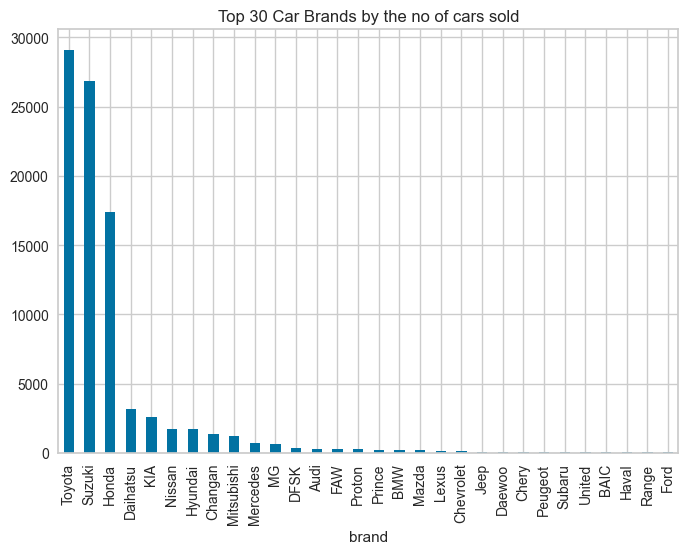

In [75]:
df.brand.value_counts().nlargest(30).plot(kind='bar')
plt.title("Top 30 Car Brands by the no of cars sold")
plt.show()

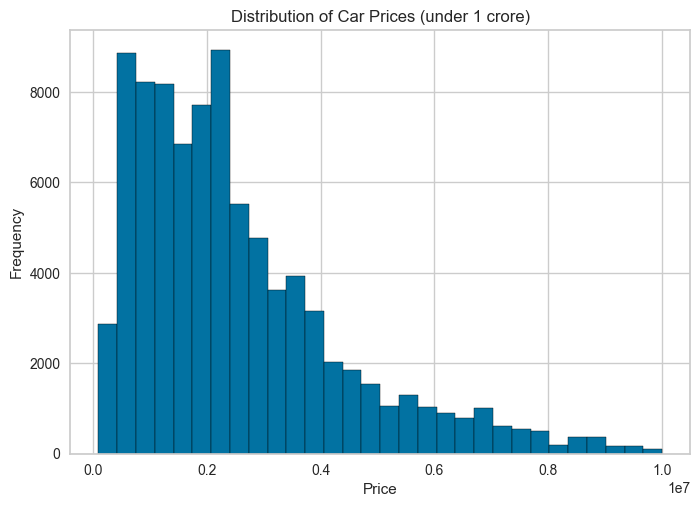

In [76]:
filtered_prices = df[df['price'] < 10000000]['price']
plt.hist(filtered_prices, bins=30, edgecolor='black')
plt.title("Distribution of Car Prices (under 1 crore)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

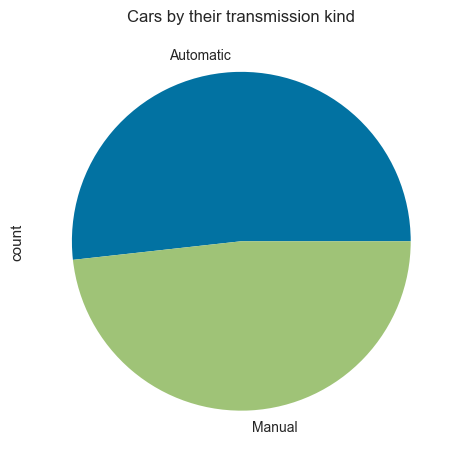

In [77]:
df.transmission.value_counts().plot(kind='pie')
plt.title("Cars by their transmission kind")
plt.show()

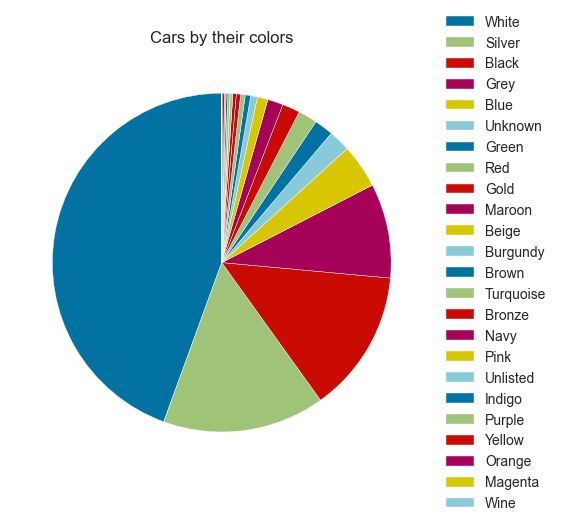

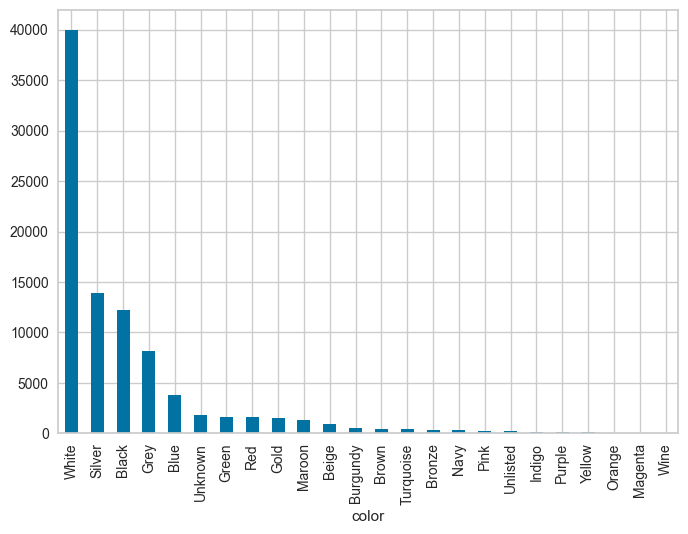

In [78]:
plt.pie(df.color.value_counts(), startangle=90, wedgeprops=dict(edgecolor='w'))
plt.title("Cars by their colors")

# Manually add the legend
plt.legend(df.color.value_counts().index, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

df.color.value_counts().plot(kind='bar')
plt.show()

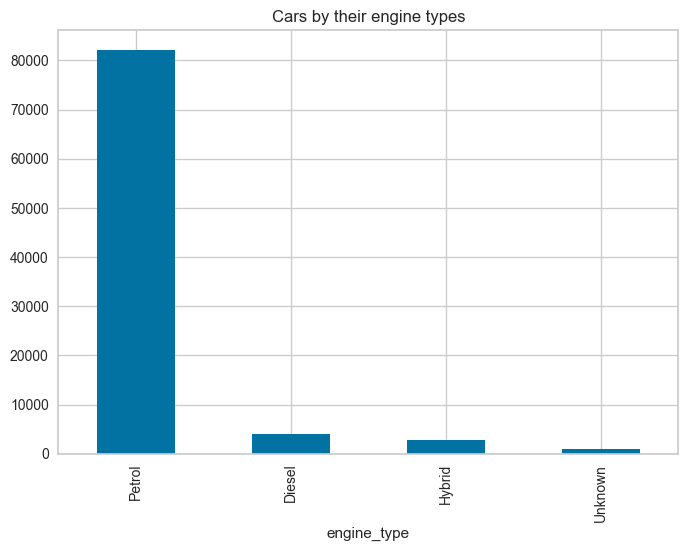

In [79]:
df.engine_type.value_counts().plot(kind='bar')
plt.title("Cars by their engine types")
plt.show()

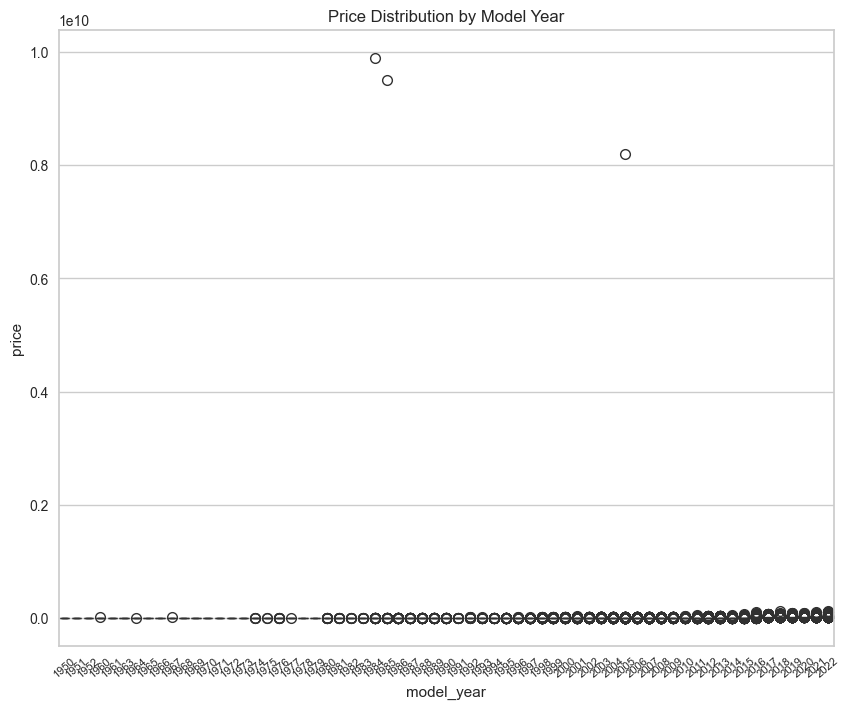

In [80]:
plt.figure(figsize=(10,8))
sns.boxplot(x='model_year', y='price', data=df)
plt.xticks(rotation=40,fontsize = 8)
plt.title('Price Distribution by Model Year')

plt.show()

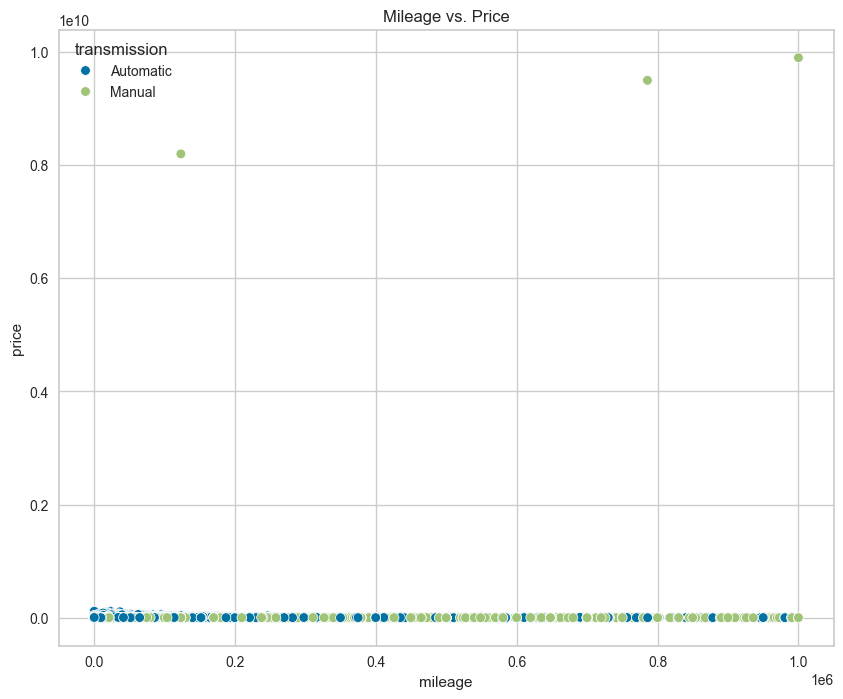

In [81]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='mileage', y='price', data=df , hue="transmission")
plt.title('Mileage vs. Price')
plt.show()

In [82]:
df = df[df['price'] < 40000000] #dropping the extreeme values ( the 3 outliers)

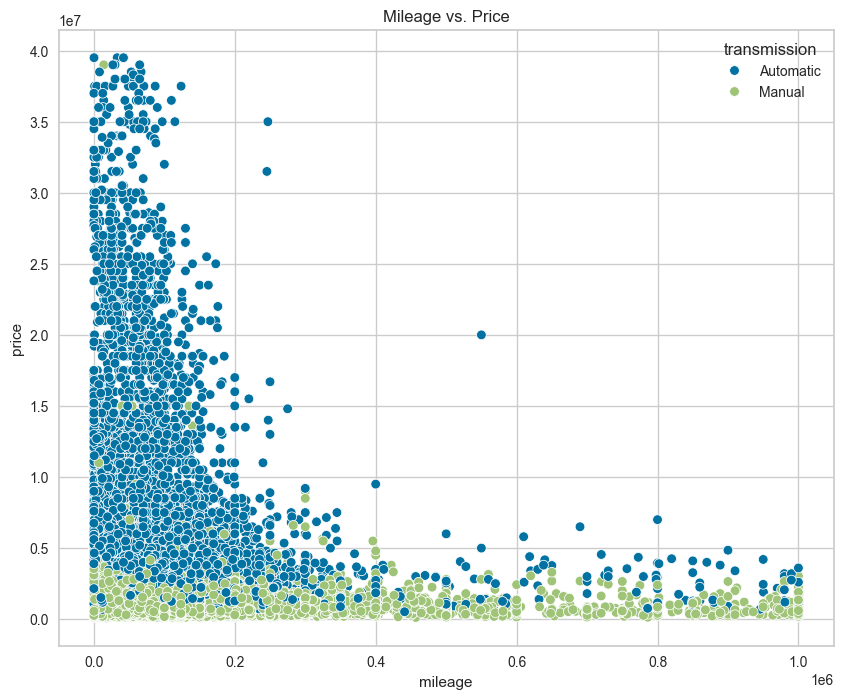

In [83]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='mileage', y='price', data=df , hue="transmission")
plt.title('Mileage vs. Price')
plt.show()

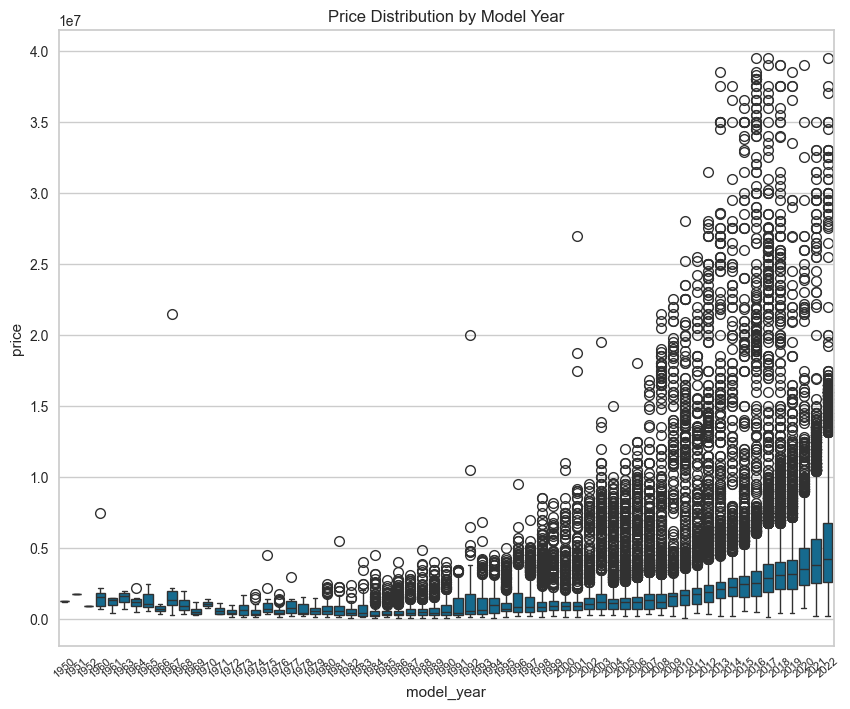

In [84]:
plt.figure(figsize=(10,8))
sns.boxplot(x='model_year', y='price', data=df)
plt.xticks(rotation=40,fontsize = 8)
plt.title('Price Distribution by Model Year')

plt.show()

In [86]:
sns.heatmap(df.corr() , annot=True)
plt.show()

ValueError: could not convert string to float: ' Islamabad Islamabad'

# Trainning the ML model

In [87]:
X = df[['model_year', 'mileage', 'engine_capacity','ev','has_ac']]
y = df['price']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
model = LinearRegression()

In [91]:
model.fit(X_train, y_train)

LinearRegression()

In [92]:
y_pred = model.predict(X_test)

In [93]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 5006334184744.721


In [94]:
df.head()

,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,...,ad_last_updated,car_features,brand,vehicle,make,ev,current_city,has_ac,cleaned_description,age
0,Islamabad Islamabad,2007,1650000.0,100000,Petrol,Automatic,Lahore,Grey,Imported Cars,1800.0,...,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,Honda,Civic,VTi Oriel Prosmatec 1.8 i-VTEC,0,Islamabad,1,2007 model full option chat piller geniune inn...,16
1,"Eden Gardens, Faisalabad Punjab",2012,700000.0,100000,Petrol,Manual,Faisalabad,Grey,Imported Cars,800.0,...,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,Suzuki,Mehran,VX Euro II,0,Faisalabad,0,smooth drive 70 orignal paint rest shower with...,11
2,"Bostan Road, Rawalpindi Punjab",1995,760000.0,999,Petrol,Manual,Lahore,Black,Imported Cars,1500.0,...,2022-10-09,AM/FM Radio\nAir Conditioning\nAlloy Rims\nCas...,Honda,Civic,EX,0,Rawalpindi,1,1600cc engine installed alloy rimsair conditio...,28
3,"Kallar Kahar Road, Chakwal Punjab",2013,7000000.0,94000,Petrol,Automatic,Lahore,Black,Imported Cars,2700.0,...,2022-10-09,ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,Toyota,Fortuner,2.7 VVTi,0,Chakwal,1,inside fully original original return file ava...,10
4,Muzaffar Gargh Punjab,2015,800000.0,86000,Petrol,Manual,Multan,Grey,Imported Cars,796.0,...,2022-10-09,AM/FM Radio\nCD Player\nImmobilizer Key,Suzuki,Mehran,VX Euro II,0,Muzaffar Gargh,0,gari total genion hy chill c new tires work re...,8


In [95]:
new_data = pd.DataFrame({'model_year': [2007], 'mileage': [100000], 'engine_capacity': [1800], 'ev': [0], 'has_ac': [1]})

# Make predictions for the new data
predicted_price = model.predict(new_data)

rounded_price = round(predicted_price[0] / 1000) * 1000

# Display the rounded price
print(f'Predicted Rounded Price: {rounded_price}')

Predicted Rounded Price: 3100000


As we are getting very bad results and mse with liner regression we try different model.
# Using CNN MODEL

In [101]:
selected_features = ['model_year', 'mileage', 'engine_type', 'transmission', 'registered_in', 'assembly', 'engine_capacity', 'make', 'ev', 'has_ac', 'current_city', 'price']
df_selected = df[selected_features]

label_encoders = {}
categorical_columns = ['engine_type', 'transmission', 'registered_in', 'assembly', 'make', 'current_city']

# Use LabelEncoder for categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    df_selected[col] = le.fit_transform(df_selected[col])
    label_encoders[col] = le

# Scale numerical features
numerical_features = ['model_year', 'mileage', 'engine_capacity']
scaler = StandardScaler()
df_selected[numerical_features] = scaler.fit_transform(df_selected[numerical_features])

# Split the data into features (X) and target (y)
X = df_selected.drop('price', axis=1)
y = df_selected['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create embedding layers for categorical columns
embedding_layers = []
input_layers = []

for col in categorical_columns:
    input_dim = len(label_encoders[col].classes_)
    output_dim = min(5, input_dim)
    input_layer = Input(shape=(1,))
    embedding_layer = Embedding(input_dim=input_dim, output_dim=output_dim)(input_layer)
    input_layers.append(input_layer)
    embedding_layers.append(embedding_layer)

# Concatenate the embeddings
concatenated_embeddings = concatenate(embedding_layers, axis=-1)

# Adjusted kernel size to 1
output = Conv1D(filters=64, kernel_size=1, activation='relu')(concatenated_embeddings)
output = MaxPooling1D(pool_size=1)(output)  # Decreased pooling factor
output = Flatten()(output)
output = Dense(64, activation='relu')(output)
output = Dense(1, activation='linear')(output)

# Create a Model instance
model = Model(inputs=input_layers, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Convert input data to numpy arrays
X_train_inputs = [X_train[col].to_numpy() for col in categorical_columns]
X_test_inputs = [X_test[col].to_numpy() for col in categorical_columns]

# Fit the model
model.fit(X_train_inputs, y_train, epochs=10, batch_size=32, validation_data=(X_test_inputs, y_test))

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14176\1580475717.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = le.fit_transform(df_selected[col])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14176\1580475717.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = le.fit_transform(df_selected[col])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14176\1580475717.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Epoch 1/10
2244/2244 [==============================] - 13s 4ms/step - loss: 13132155060224.0000 - val_loss: 8393903308800.0000
Epoch 2/10
2244/2244 [==============================] - 8s 4ms/step - loss: 6958543273984.0000 - val_loss: 6304366067712.0000
Epoch 3/10
2244/2244 [==============================] - 8s 4ms/step - loss: 5563826044928.0000 - val_loss: 5417613131776.0000
Epoch 4/10
2244/2244 [==============================] - 8s 4ms/step - loss: 4821915009024.0000 - val_loss: 4800497319936.0000
Epoch 5/10
2244/2244 [==============================] - 8s 4ms/step - loss: 4301251411968.0000 - val_loss: 4310573252608.0000
Epoch 6/10
2244/2244 [==============================] - 9s 4ms/step - loss: 3893859713024.0000 - val_loss: 3914548903936.0000
Epoch 7/10
2244/2244 [==============================] - 8s 3ms/step - loss: 3575421861888.0000 - val_loss: 3609109987328.0000
Epoch 8/10
2244/2244 [==============================] - 8s 4ms/step - loss: 3330478440448.0000 - val_loss: 337594993

In [103]:
# Split X_test into separate inputs
X_test_inputs = [X_test[col].to_numpy() for col in categorical_columns]

# Evaluate the model
loss = model.evaluate(X_test_inputs, y_test)
print(f'Mean Squared Error on Test Data: {loss}')


  1/561 [..............................] - ETA: 57s - loss: 1350370459648.0000

561/561 [==============================] - 2s 4ms/step - loss: 3056114860032.0000
Mean Squared Error on Test Data: 3056114860032.0


In [104]:
# Split X_test into separate inputs
X_test_inputs = [X_test[col] for col in categorical_columns]

# Make predictions
predictions = model.predict(X_test_inputs)

561/561 [==============================] - 2s 3ms/step


In [105]:
print(predictions)

[[1129625.9]
 [4024580. ]
 [2251011. ]
 ...
 [1151433.4]
 [2147903.5]
 [7196521. ]]


# KMeans Clustring

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The 

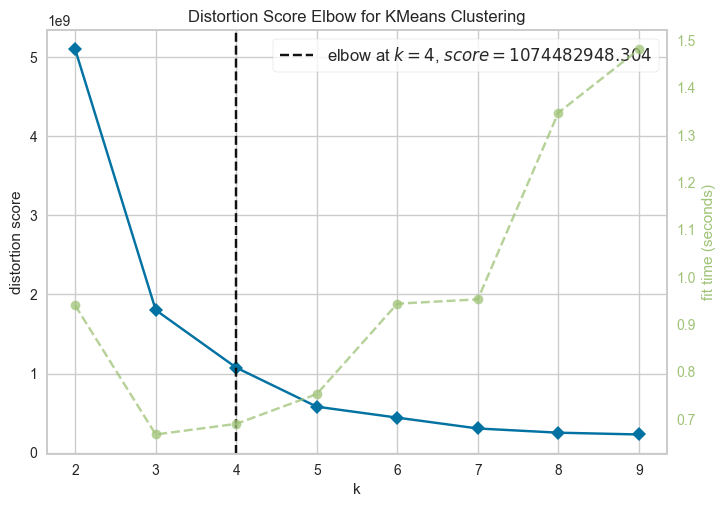

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


               model_year   mileage  engine_type  transmission  registered_in  \
cluster_label                                                                   
0                0.218398 -0.099369     1.709493      0.373230      86.228081   
1                0.261251 -0.203034     1.878570      0.298688      86.802016   
2               -0.100334  0.072585     1.970932      0.680648      82.871862   
3               -0.337544  0.222145     1.910876      0.528897      81.606846   

               assembly  engine_capacity         make        ev    has_ac  \
cluster_label                                                               
0              0.591058         0.166332   946.040943  0.000349  0.942666   
1              0.709755         0.181697   143.092527  0.003613  0.832820   
2              0.823464        -0.271513  1321.023767  0.000108  0.833995   
3              0.617367         0.017119   626.962920  0.000748  0.906154   

               current_city         price  
cluste

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14176\365865544.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['cluster_label'] = kmeans_model.labels_


In [106]:
# Encode categorical features
X = df_selected.drop('price', axis=1)

# Initialize label encoders for each categorical column
label_encoders = {col: LabelEncoder() for col in categorical_columns}

# Fit label encoders on the entire categorical column
for col in categorical_columns:
    label_encoders[col].fit(X[col])

# Transform categorical features
for col in categorical_columns:
    X[col] = label_encoders[col].transform(X[col])

# Standardize numerical features
scaler = StandardScaler()
X[['model_year', 'mileage', 'engine_capacity']] = scaler.fit_transform(X[['model_year', 'mileage', 'engine_capacity']])

# Use the elbow method to find the optimal number of clusters
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Display the figure

# Get the optimal number of clusters
optimal_clusters = visualizer.elbow_value_

# Train K-Means model with the optimal number of clusters
kmeans_model = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_model.fit(X)

# Add cluster labels to the original DataFrame
df_selected['cluster_label'] = kmeans_model.labels_

# Explore the clusters
cluster_means = df_selected.groupby('cluster_label').mean()
print(cluster_means)

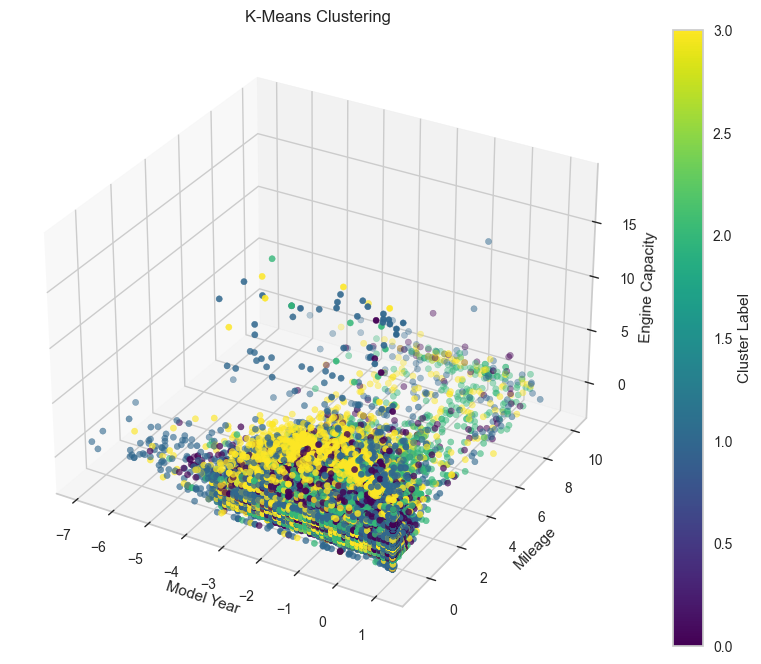

In [107]:

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the first three features (adjust as needed)
scatter = ax.scatter(X['model_year'], X['mileage'], X['engine_capacity'], c=df_selected['cluster_label'], cmap='viridis')

# Add labels and title
ax.set_xlabel('Model Year')
ax.set_ylabel('Mileage')
ax.set_zlabel('Engine Capacity')
ax.set_title('K-Means Clustering')

# Add a colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Label')

# Show the plot
plt.show()


# KNN MODEL

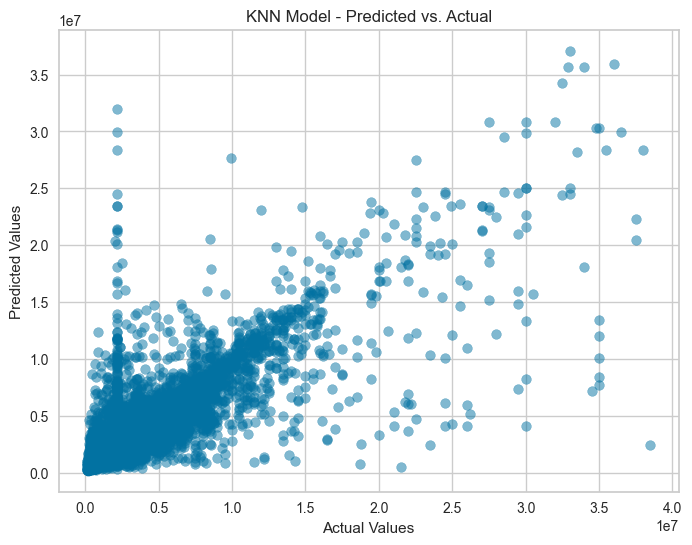

Mean Squared Error: 2895496533210.028
Mean Absolute Error: 633308.3899721449
R-squared: 0.702360806855046


In [108]:


X = df_selected.drop('price', axis=1)
y = df_selected['price']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train[['model_year', 'mileage', 'engine_capacity']] = scaler.fit_transform(X_train[['model_year', 'mileage', 'engine_capacity']])
X_test[['model_year', 'mileage', 'engine_capacity']] = scaler.transform(X_test[['model_year', 'mileage', 'engine_capacity']])

# Train KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test)


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('KNN Model - Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Bagging Ensable CNN

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14176\2699835488.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = le.fit_transform(df_selected[col])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14176\2699835488.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = le.fit_transform(df_selected[col])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14176\2699835488.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Epoch 1/10
2244/2244 [==============================] - 12s 4ms/step - loss: 13517367279616.0000 - val_loss: 8618770956288.0000
Epoch 2/10
2244/2244 [==============================] - 8s 3ms/step - loss: 7170213019648.0000 - val_loss: 6457351733248.0000
Epoch 3/10
2244/2244 [==============================] - 8s 3ms/step - loss: 5705246965760.0000 - val_loss: 5542079102976.0000
Epoch 4/10
2244/2244 [==============================] - 8s 3ms/step - loss: 4945466621952.0000 - val_loss: 4923168653312.0000
Epoch 5/10
2244/2244 [==============================] - 8s 3ms/step - loss: 4415108415488.0000 - val_loss: 4430238318592.0000
Epoch 6/10
2244/2244 [==============================] - 8s 3ms/step - loss: 3996834856960.0000 - val_loss: 4017940594688.0000
Epoch 7/10
2244/2244 [==============================] - 8s 3ms/step - loss: 3664155246592.0000 - val_loss: 3700725383168.0000
Epoch 8/10
2244/2244 [==============================] - 8s 3ms/step - loss: 3408360898560.0000 - val_loss: 346129537

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


561/561 [==============================] - 1s 2ms/step


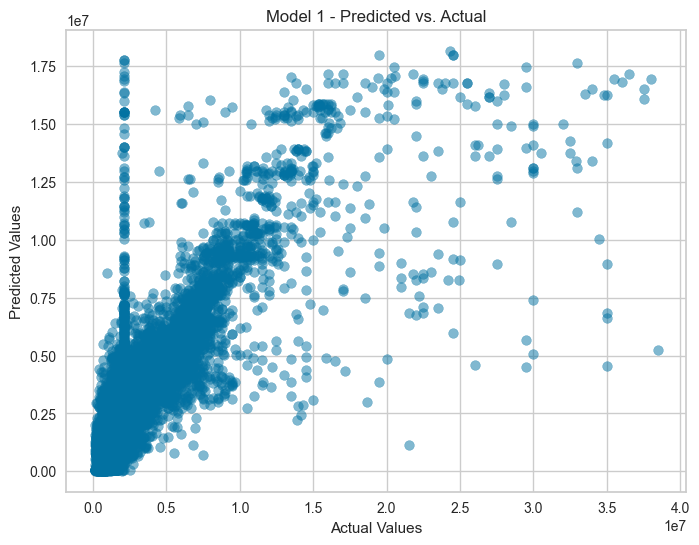

Model 1 - MAE: 764282.9678215311, R-squared: 0.6794043764696418
Epoch 1/10
2244/2244 [==============================] - 10s 3ms/step - loss: 2940760752128.0000 - val_loss: 3000981258240.0000
Epoch 2/10
2244/2244 [==============================] - 8s 4ms/step - loss: 2847245074432.0000 - val_loss: 2910380359680.0000
Epoch 3/10
2244/2244 [==============================] - 8s 3ms/step - loss: 2769534582784.0000 - val_loss: 2837304836096.0000
Epoch 4/10
2244/2244 [==============================] - 8s 3ms/step - loss: 2707503972352.0000 - val_loss: 2772949270528.0000
Epoch 5/10
2244/2244 [==============================] - 7s 3ms/step - loss: 2655084609536.0000 - val_loss: 2724514758656.0000
Epoch 6/10
2244/2244 [==============================] - 8s 3ms/step - loss: 2612520026112.0000 - val_loss: 2684662579200.0000
Epoch 7/10
2244/2244 [==============================] - 8s 3ms/step - loss: 2576364863488.0000 - val_loss: 2652845113344.0000
Epoch 8/10
2244/2244 [==============================]

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


561/561 [==============================] - 1s 2ms/step


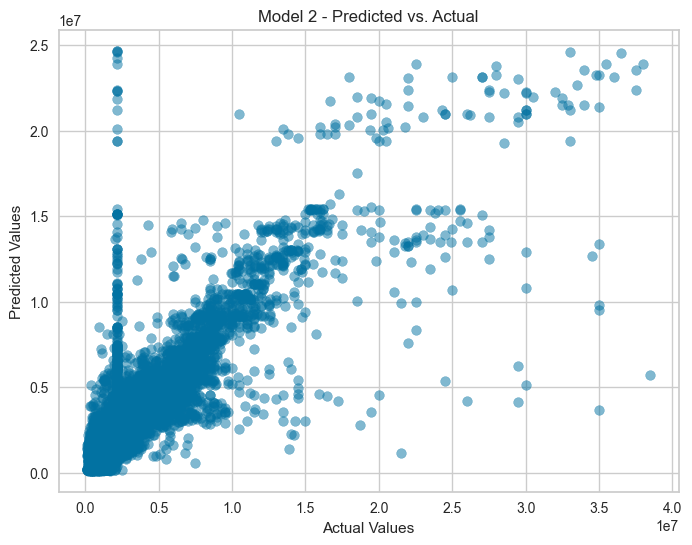

Model 2 - MAE: 706769.3272562674, R-squared: 0.7342887292515226
Epoch 1/10
2244/2244 [==============================] - 10s 4ms/step - loss: 2472860188672.0000 - val_loss: 2571641290752.0000
Epoch 2/10
2244/2244 [==============================] - 8s 3ms/step - loss: 2454228303872.0000 - val_loss: 2559203868672.0000
Epoch 3/10
2244/2244 [==============================] - 8s 3ms/step - loss: 2436729667584.0000 - val_loss: 2545034199040.0000
Epoch 4/10
2244/2244 [==============================] - 8s 3ms/step - loss: 2420215906304.0000 - val_loss: 2537872949248.0000
Epoch 5/10
2244/2244 [==============================] - 9s 4ms/step - loss: 2403798614016.0000 - val_loss: 2526673108992.0000
Epoch 6/10
2244/2244 [==============================] - 8s 3ms/step - loss: 2389891350528.0000 - val_loss: 2520557551616.0000
Epoch 7/10
2244/2244 [==============================] - 8s 3ms/step - loss: 2376937242624.0000 - val_loss: 2513677582336.0000
Epoch 8/10
2244/2244 [==============================]

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


561/561 [==============================] - 1s 1ms/step


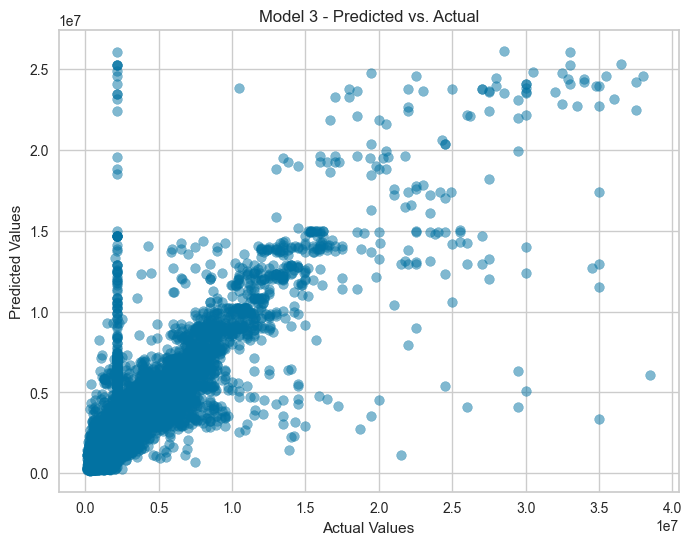

Model 3 - MAE: 695481.2058165042, R-squared: 0.7430463966180205
Epoch 1/10
2244/2244 [==============================] - 7s 2ms/step - loss: 2332165931008.0000 - val_loss: 2498812968960.0000
Epoch 2/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2323211616256.0000 - val_loss: 2494374346752.0000
Epoch 3/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2314063839232.0000 - val_loss: 2496524451840.0000
Epoch 4/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2305163526144.0000 - val_loss: 2489300287488.0000
Epoch 5/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2296988303360.0000 - val_loss: 2490301939712.0000
Epoch 6/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2289659019264.0000 - val_loss: 2487718510592.0000
Epoch 7/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2282585849856.0000 - val_loss: 2484347863040.0000
Epoch 8/10
2244/2244 [==============================] 

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


561/561 [==============================] - 1s 2ms/step


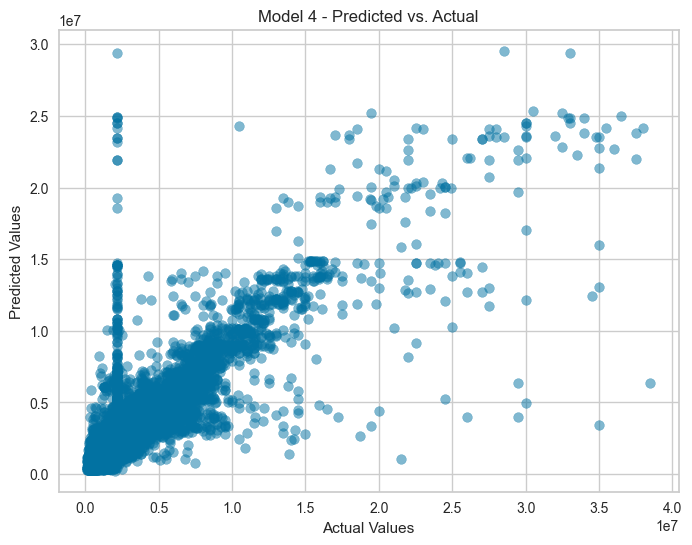

Model 4 - MAE: 689423.4235036559, R-squared: 0.7448199960265995
Epoch 1/10
2244/2244 [==============================] - 8s 2ms/step - loss: 2257301012480.0000 - val_loss: 2482533826560.0000
Epoch 2/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2252200214528.0000 - val_loss: 2480491724800.0000
Epoch 3/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2246635945984.0000 - val_loss: 2480389488640.0000
Epoch 4/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2241586266112.0000 - val_loss: 2479300804608.0000
Epoch 5/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2235506622464.0000 - val_loss: 2476756172800.0000
Epoch 6/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2230715154432.0000 - val_loss: 2480060760064.0000
Epoch 7/10
2244/2244 [==============================] - 5s 2ms/step - loss: 2225857101824.0000 - val_loss: 2478900248576.0000
Epoch 8/10
2244/2244 [==============================] 

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


561/561 [==============================] - 1s 1ms/step


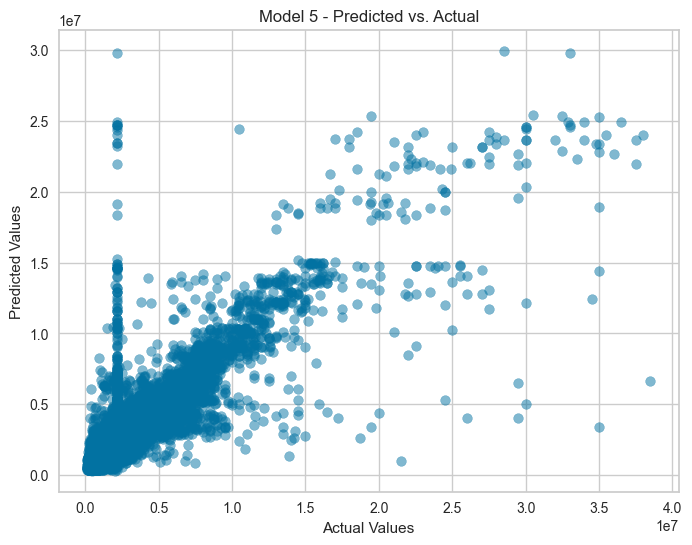

Model 5 - MAE: 688380.2371674791, R-squared: 0.745278319598009
Ensemble model saved to saved_models\ensemble_model.h5


C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


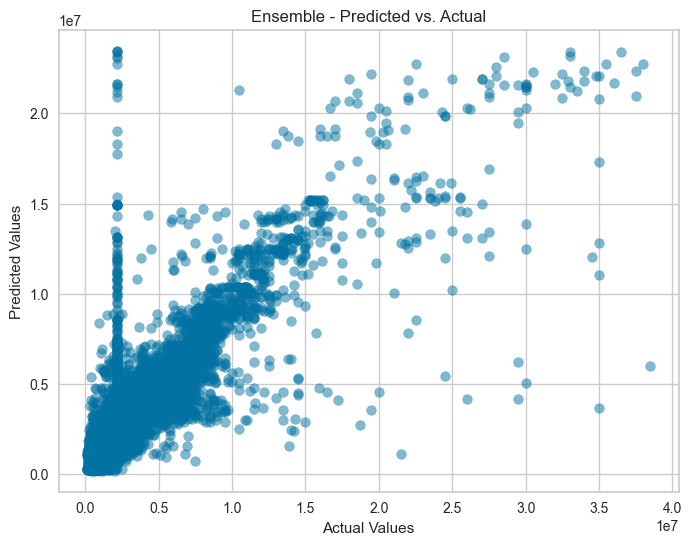

Ensemble Metrics - MAE: 698735.2730806059, R-squared: 0.7404222085180979


In [111]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from keras.models import Model
import matplotlib.pyplot as plt

# Assuming you have the necessary imports and data loading above this point

selected_features = ['model_year', 'mileage', 'engine_type', 'transmission', 'registered_in', 'assembly',
                     'engine_capacity', 'make', 'ev', 'has_ac', 'current_city', 'price']
df_selected = df[selected_features]

label_encoders = {}
categorical_columns = ['engine_type', 'transmission', 'registered_in', 'assembly', 'make', 'current_city']

for col in categorical_columns:
    le = LabelEncoder()
    df_selected[col] = le.fit_transform(df_selected[col])
    label_encoders[col] = le

X = df_selected.drop('price', axis=1)
y = df_selected['price']

scaler = StandardScaler()
X[['model_year', 'mileage', 'engine_capacity']] = scaler.fit_transform(X[['model_year', 'mileage', 'engine_capacity']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

embedding_layers = []
input_layers = []

for col in categorical_columns:
    input_dim = len(label_encoders[col].classes_)
    output_dim = min(5, input_dim)
    input_layer = Input(shape=(1,))
    embedding_layer = Embedding(input_dim=input_dim, output_dim=output_dim)(input_layer)
    input_layers.append(input_layer)
    embedding_layers.append(embedding_layer)

concatenated_embeddings = concatenate(embedding_layers, axis=-1)
output = Conv1D(filters=64, kernel_size=1, activation='relu')(concatenated_embeddings)
output = MaxPooling1D(pool_size=1)(output)
output = Flatten()(output)
output = Dense(64, activation='relu')(output)
output = Dense(1, activation='linear')(output)

model = Model(inputs=input_layers, outputs=output)

num_models = 5

save_dir = 'saved_models'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Lists to store models and predictions
models = []
predictions_list = []

# Bagging loop with different random seeds for each model
for i in range(num_models):
    # Reset the random seed for each iteration
    np.random.seed(i)

    # Create a new model instance with a unique seed
    model = Model(inputs=input_layers, outputs=output)

    # Place the random seed before compiling the model
    np.random.seed(i)

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Split X_train and X_test into separate inputs
    X_train_inputs = [X_train[col].to_numpy() for col in categorical_columns]
    X_test_inputs = [X_test[col].to_numpy() for col in categorical_columns]

    # Fit the model
    model.fit(X_train_inputs, y_train, epochs=10, batch_size=32, validation_data=(X_test_inputs, y_test))

    # Save the model
    model_path = os.path.join(save_dir, f'model_{i + 1}.h5')
    model.save(model_path)
    print(f'Model {len(models)} saved to {model_path}')

    # Store the model
    models.append(model)

    # Make predictions
    predictions = model.predict(X_test_inputs)
    predictions_list.append(predictions)

    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)

    # Calculate R-squared
    r2 = r2_score(y_test, predictions)

    # Visualize predicted vs. actual values for each model
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.title(f'Model {len(models)} - Predicted vs. Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    print(f'Model {len(models)} - MAE: {mae}, R-squared: {r2}')

# Average predictions from all models
ensemble_predictions = np.mean(predictions_list, axis=0)

# Calculate metrics for the ensemble
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)
ensemble_r2 = r2_score(y_test, ensemble_predictions)

# Save the ensemble model
ensemble_model_path = os.path.join(save_dir, 'ensemble_model.h5')
model.save(ensemble_model_path)
print(f'Ensemble model saved to {ensemble_model_path}')

# Visualize predicted vs. actual values for the ensemble
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ensemble_predictions, alpha=0.5)
plt.title('Ensemble - Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print(f'Ensemble Metrics - MAE: {ensemble_mae}, R-squared: {ensemble_r2}')


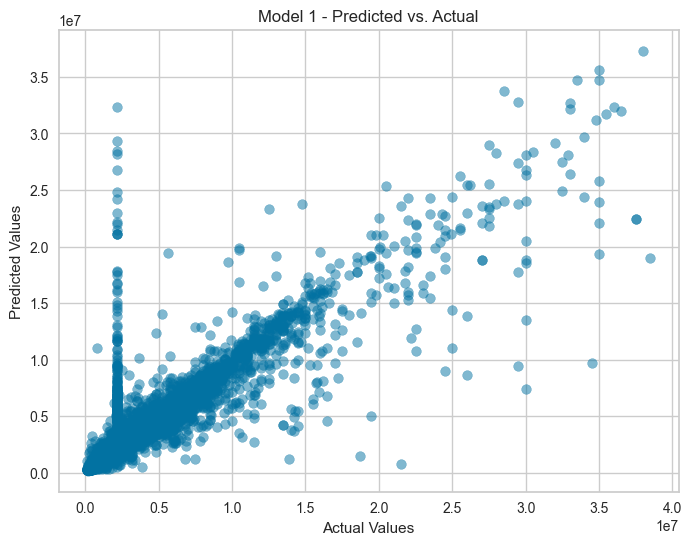

Model 1 - MAE: 365255.3624289163, R-squared: 0.8359420989565377


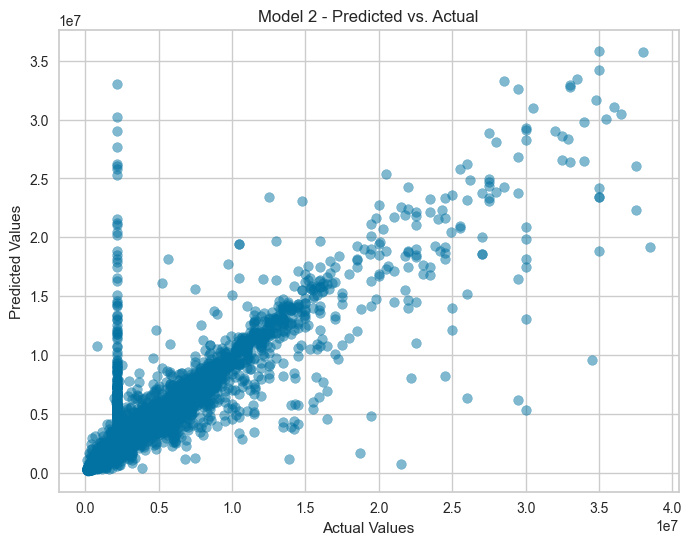

Model 2 - MAE: 366730.5926367833, R-squared: 0.8321206922700445


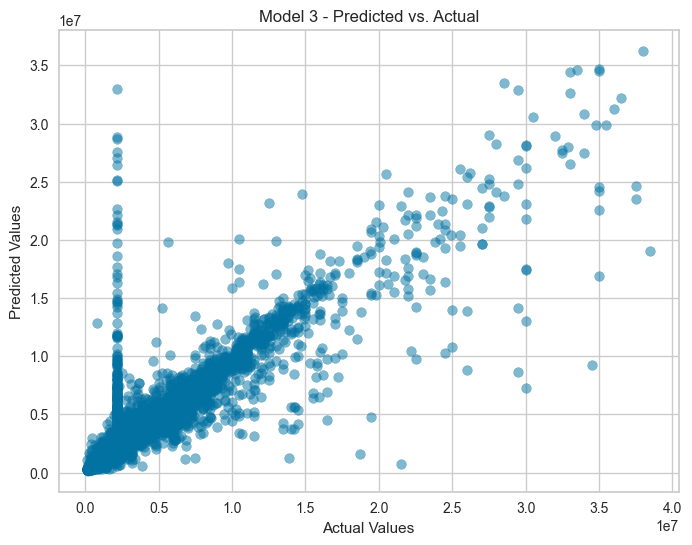

Model 3 - MAE: 366873.44828029093, R-squared: 0.8327306924367837


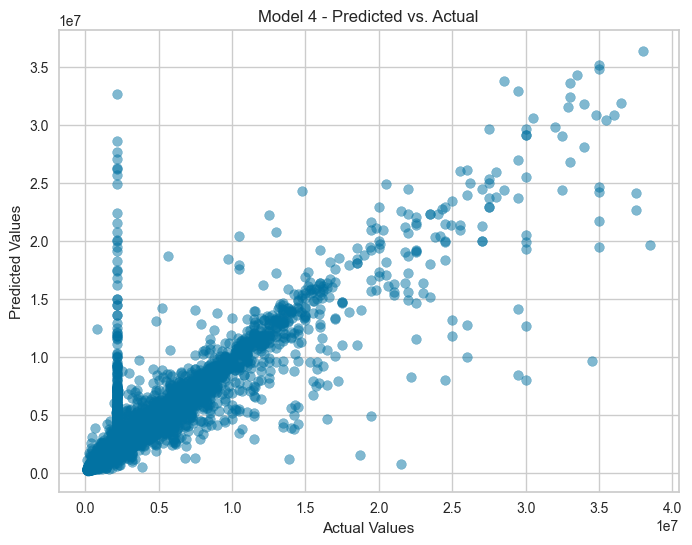

Model 4 - MAE: 364487.0145053533, R-squared: 0.8370824520017665


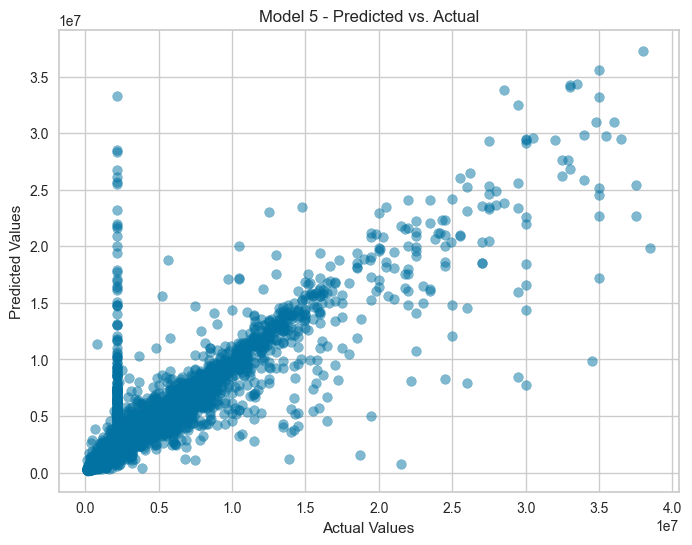

Model 5 - MAE: 366066.25928854366, R-squared: 0.8356216613942157


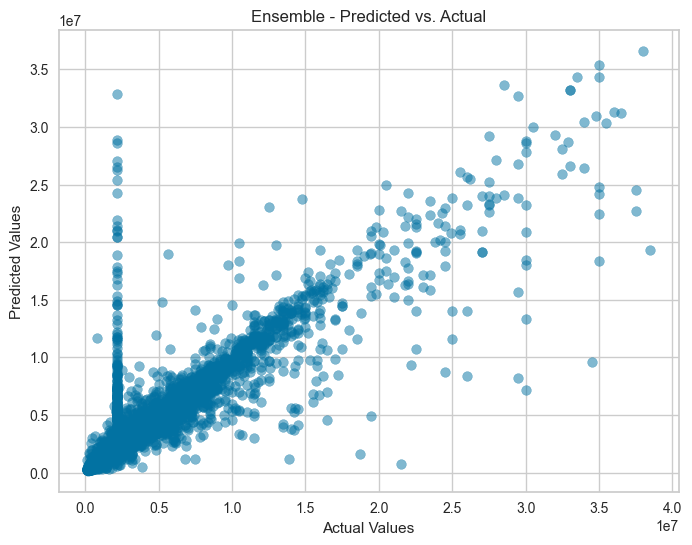

Ensemble Metrics - MAE: 364343.23080127634, R-squared: 0.8356739849178572


In [114]:
# Assuming you have the necessary imports and data loading above this point
from sklearn.ensemble import RandomForestRegressor
selected_features = ['model_year', 'mileage', 'engine_type', 'transmission', 'registered_in', 'assembly',
                     'engine_capacity', 'make', 'ev', 'has_ac', 'current_city', 'price']
df_selected = df[selected_features]

# One-hot encode categorical features
df_selected = pd.get_dummies(df_selected, columns=['engine_type', 'transmission', 'registered_in', 'assembly', 'make', 'current_city'])

X = df_selected.drop('price', axis=1)
y = df_selected['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_models = 5

# Lists to store models, predictions, and metrics
models = []
predictions_list = []
mae_list = []
r2_list = []

# Bagging loop with different random seeds for each model
for i in range(num_models):
    # Reset the random seed for each iteration
    np.random.seed(i)

    # Create a new Random Forest Regressor instance with a unique seed
    model = RandomForestRegressor(n_estimators=100, random_state=i)  # You can adjust parameters as needed

    # Fit the model
    model.fit(X_train, y_train)

    # Store the model
    models.append(model)

    # Make predictions
    predictions = model.predict(X_test)
    predictions_list.append(predictions)

    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)
    mae_list.append(mae)

    # Calculate R-squared
    r2 = r2_score(y_test, predictions)
    r2_list.append(r2)

    # Visualize predicted vs. actual values for each model
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.title(f'Model {i + 1} - Predicted vs. Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    print(f'Model {i + 1} - MAE: {mae}, R-squared: {r2}')

# Average predictions from all models
ensemble_predictions = np.mean(predictions_list, axis=0)

# Calculate metrics for the ensemble
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)
ensemble_r2 = r2_score(y_test, ensemble_predictions)

# Visualize predicted vs. actual values for the ensemble
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ensemble_predictions, alpha=0.5)
plt.title('Ensemble - Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print(f'Ensemble Metrics - MAE: {ensemble_mae}, R-squared: {ensemble_r2}')
